# Option Pricing using Geometric Brownian Motion (GBM) and Monte Carlo Simulation

In this notebook, we will estimate the price of a stock option by using a Monte Carlo method based on the Geometric Brownian Motion (GBM) model of stock prices. This model assumes that the logarithmic returns of stock prices are normally distributed and that they can be modeled as a Brownian motion with drift.

The GBM model is defined as:
S(t) = S(0) * exp((mu - 0.5 * sigma^2) * t + sigma * W(t))

where:

- S(t) is the stock price at time t
- S(0) is the initial stock price
- mu is the expected return (drift coefficient)
- sigma is the standard deviation of returns (diffusion coefficient)
- W(t) is a random variable following a standard normal distribution

By simulating multiple paths of the stock price using this model, we can then calculate the payoff of the option for each path at maturity, and estimate the price of the option as the average payoff discounted back to the present value.

## Exercise Review

In this exercise, our main objective is to predict the 1-day-ahead price of a call and put option, utilizing the Geometric Brownian Motion (GBM) model in combination with Monte Carlo simulation. The GBM model, which characterizes the behavior of stock prices, will be instrumental in generating multiple potential paths that the stock price might follow. With these simulated paths, we will calculate the associated payoff of the option at maturity and estimate the option's price.



After we have the predicted prices for the call or put option, we will compare these prices with the actual option prices. This comparison serves as an assessment of the performance and accuracy of our model.

## Package Imports

In [5]:
import numpy as np
import pandas as pd
import finpy_tse as fpy
import matplotlib.pyplot as plt

## GBM Option Pricing Function

We define the function `gbm_option_prices()` to compute the price of a European call and put option using the Geometric Brownian Motion (GBM) model. This function is designed with the following parameters:

- The initial stock price
- The strike price of the option
- The time-to-maturity of the option
- The volatility of the underlying stock
- The risk-free rate of return (optional parameter with default value)
- The number of time steps in the GBM model (optional parameter with default value)
- The number of simulated paths in the Monte Carlo simulation (optional parameter with default value)
- A flag indicating whether to plot the first 100 simulated paths (optional parameter with default value)
- The function returns a tuple comprising the estimated prices of the European call option and the European put option.

This function primarily simulates several paths for the stock price using the GBM model, calculates the payoff of the option for each path at the time of maturity, and then estimates the price of the option as the average payoff discounted back to the present value.

For the complete information about inputs and outputs, please refer to the function's docstring.

In [2]:
def gbm_option_prices(S0: float, K: float, T: float, sigma: float,
                       r=0.0516, N=100, I=10_000,  is_plot=False) -> tuple[float, float]:
    """Calculates the price of a European call and put option using the geometric Brownian motion model.
    
    Args:
        S0 (float): initial stock price
        K (float): strike price
        T (float): time to maturity in years
        sigma (float): volatility
        r (float, optional): risk-free short rate. Defaults to 0.0516.
        N (int, optional): number of time intervals. Defaults to 100.
        I (int, optional): number of simulations. Defaults to 10_000.
        is_plot (bool, optional): plot the simulated paths. Defaults to False.
        
    Returns:
        tuple[float, float]: call and put option prices
    """
    # Simulating I paths with N time steps
    dt = T / N
    S = np.zeros((N + 1, I))
    S[0] = S0
    for t in range(1, N + 1):
        z = np.random.standard_normal(I)  # pseudorandom numbers
        S[t] = S[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z)  # GBM formula
    
    # Calculating the Monte Carlo estimator
    C0 = np.exp(-r * T) * np.sum(np.maximum(S[-1] - K, 0)) / I  # payoff function (for a call option)
    P0 = np.exp(-r * T) * np.sum(np.maximum(K - S[-1], 0)) / I  # payoff function (for a put option)
    
    if is_plot:
        # Plotting the first 100 paths
        plt.figure(figsize=(10,6))
        plt.plot(S[:,:100], lw=1.5)
        plt.title('Simulated paths of the GBM')
        plt.xlabel('Time steps')
        plt.ylabel('Stock price')
        plt.grid(True)
        plt.show()

    return C0, P0

## Choice of Option for Backtesting

In this exercise, we will be focusing on an option of SHASTA. Specifically, we will look at an option that expires on January 24, 2024.

We have chosen to backtest our model over the last 3 months leading up to the current date. Backtesting over this recent period allows us to evaluate how our model would perform under current market conditions.

The process will involve fetching the historical data for SHASTA's stock over this period, calculating its returns and volatility, and using these values as inputs to our `gbm_option_prices()` function to estimate the price of the call and put options. The estimated prices will then be compared with the actual option prices to evaluate the performance of our model.

Note: The date of expiry and the backtesting period are crucial parameters for this exercise. The date of expiry influences the time-to-maturity of the option, which is a key input to our option pricing function. The backtesting period, on the other hand, affects the historical data used to calculate the returns and volatility of the underlying stock. Different choices for these parameters can lead to different results.

In [3]:
# Parameters
ticker = "شستا"
start_date = "1401-06-01"   # stock price start date
end_date = "1402-03-21"     # stock price end date
backtest_start_date = "1402-01-01"  # backtest start date
backtest_end_date = "1402-03-21"    # backtest end date
mature_date = "1402-06-08"
K = 1465    # strike price
T = 0.23    # time-to-maturity
r = 0.23 # risk-free rate
M = 100    # number of time steps
I = 10000  # number of simulations

## Fetching Historical Stock Prices


To retrieve the historical price data of Merck's stock, we will use the yfinance package. This is a powerful Python library that allows for easy and fast downloading of stock price data from Yahoo Finance.



In [12]:
data = fpy.Get_Price_History(
            stock=ticker,
            start_date=start_date,
            end_date=end_date,
            ignore_date=False,
            adjust_price=True,
            show_weekday=False,
            double_date=False)[['Adj Close']]
returns = np.log(data['Adj Close'] / data['Adj Close'].shift(1))

## Plotting Sample Paths

Visualizing the future paths of the stock price can provide useful insights into the potential variability and trends in the price. This is particularly helpful in understanding the probabilistic nature of the Geometric Brownian Motion (GBM) model, which generates a variety of potential price paths.

In our exercise, we will plot 100 sample paths of Merck's stock price simulated using the GBM model. Each path represents a possible trajectory that the stock price could take in the future.

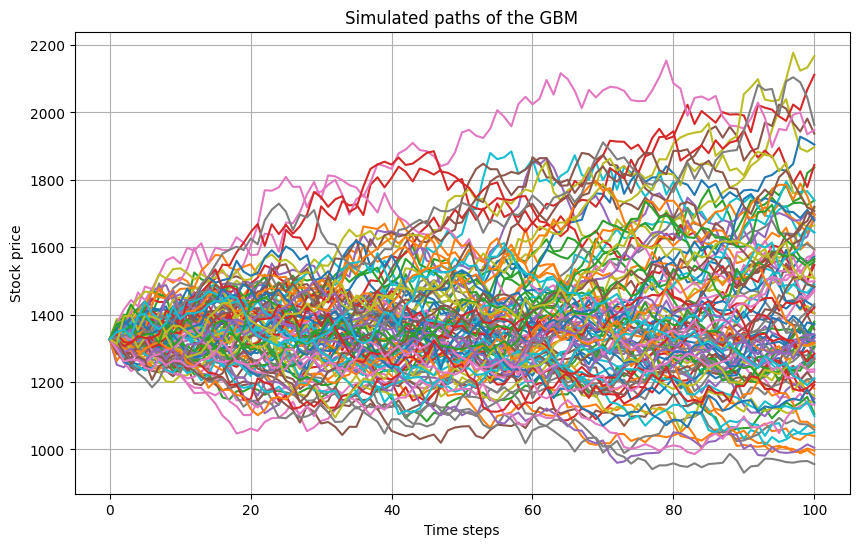

In [15]:
sigma = returns[-90:].std() * np.sqrt(252)  # annualized volatility
_ = gbm_option_prices(S0=data['Adj Close'][-1], K=K, T=T, sigma=sigma, r=r, N=M, I=I, is_plot=True)

## Reading Actual Option Prices

To validate the prices predicted by our model, we need to compare them against the actual market prices of the options. In this case, we will retrieve the actual prices of the Merck call and put options from a json file downloaded from Yahoo Finance.

In [20]:
call_df = fpy.Get_Price_History(
            stock='ضستا6010',
            start_date=start_date,
            end_date=end_date,
            ignore_date=False,
            adjust_price=True,
            show_weekday=False,
            double_date=False)[['Adj Close']]
put_df = fpy.Get_Price_History(
            stock='طستا6010',
            start_date=start_date,
            end_date=end_date,
            ignore_date=False,
            adjust_price=True,
            show_weekday=False,
            double_date=False)[['Adj Close']]

call_df.columns = ['call_actual']
put_df.columns = ['put_actual']

option_prices = call_df.join(put_df).ffill().bfill()
option_prices = option_prices.loc[backtest_start_date:]

## Backtesting the GBM Option Pricing Model

For this exercise, we have chosen the last 3 months as our backtesting period.

The general steps in backtesting our GBM option pricing model include:

1. **Extracting the Relevant Stock Price Data**: For each day in the backtesting period that we want to predict the option price for, we will extract the part of the stock price data until the day before.

1. **Calculating the Volatility**: We calculate the 30-day annualized volatility for each day in the backtesting period. The volatility is a measure of the stock price's fluctuations and is a key input to our GBM model.

1. **Calculating the Time to Maturity**: We also calculate the time to maturity for each day in the backtesting period. The time to maturity is the time from the current day to the option's expiration date, and it also affects the option's price.

1. **Predicting Option Prices**: With the stock price, volatility, and time to maturity, we can now use the `gbm_option_prices()` function to predict the call and put option prices for each day in the backtesting period.

We perform these steps for each day in the backtesting period, effectively making a new prediction for each day based on the available data up to that day. We then compare these predicted prices with the actual option prices to evaluate our model's performance.

Please note that while we use the GBM model for this exercise, in practice, option pricing can be influenced by many other factors not captured by this model, such as changes in market sentiment, liquidity, and dividend payments. Therefore, the backtesting results should be interpreted with these considerations in mind.

In [33]:
from persiantools.jdatetime import JalaliDate
def to_greg(date):
    yr, mnt, day = date.split('-')
    return JalaliDate(int(yr), int(mnt), int(day)).to_gregorian()

In [36]:
option_prices.index = [to_greg(x) for x in option_prices.index]
data.index = [to_greg(x) for x in data.index]

In [43]:
call_prices = []
put_prices = []
for date in option_prices[to_greg(backtest_start_date):].index:
    data_chunk = data.loc[:date]
    data_chunk = data_chunk[1:]
    returns = np.log(data_chunk['Adj Close'] / data_chunk['Adj Close'].shift(1))
    sigma = np.sqrt(252) * returns[-30:].std()
    S0 = data_chunk['Adj Close'][-1]
    T = (to_greg(mature_date) - date).days / 365
    C0, P0 = gbm_option_prices(S0, K, T, sigma, r, M, I)
    call_prices.append(C0)
    put_prices.append(P0)

Once we have the predicted option prices and the actual option prices, it's useful to join these data into a single DataFrame for comparison and visualization purposes. We'll create a DataFrame that includes the date, predicted call price, actual call price, predicted put price, and actual put price.

In [45]:
call_prices = pd.Series(call_prices, index=option_prices[to_greg(backtest_start_date):].index)
put_prices = pd.Series(put_prices, index=option_prices[to_greg(backtest_start_date):].index)

option_prices['call_pred'] = call_prices
option_prices['put_pred'] = put_prices

## Plotting Actual vs. Predicted Call Option Prices

In the following cell, we create a graph to visualize the actual and predicted prices of the call option. This visualization helps us in assessing the performance of our Geometric Brownian Motion model.



After inspecting the graph, we can notice that our model consistently underestimates the actual price of the call option. This discrepancy might be due to various factors not captured by our model, including changes in market sentiment, liquidity, and implied volatility. As we progress, we'll delve deeper into these aspects and work towards refining our model.






<Axes: title={'center': 'SHASTA Call Option Prices'}>

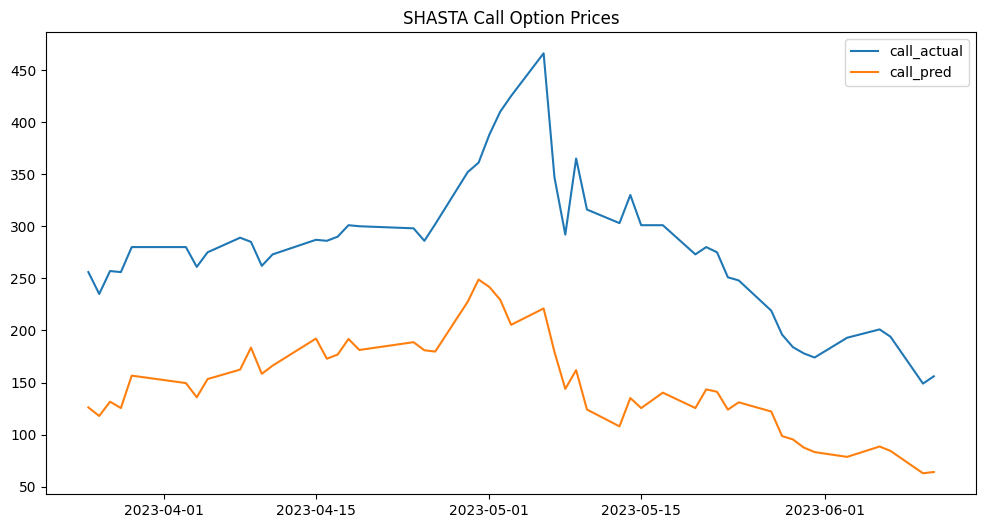

In [47]:
option_prices[['call_actual', 'call_pred']].plot(figsize=(12, 6), title='SHASTA Call Option Prices')

Next, we plot both predicted and actual prices of the put option.

Our observations show that the GBM model persistently underestimates the actual put option prices. This underscores the model's limitations and the complexity of market dynamics not captured by the model.

<Axes: title={'center': 'SHASTA Put Option Prices'}>

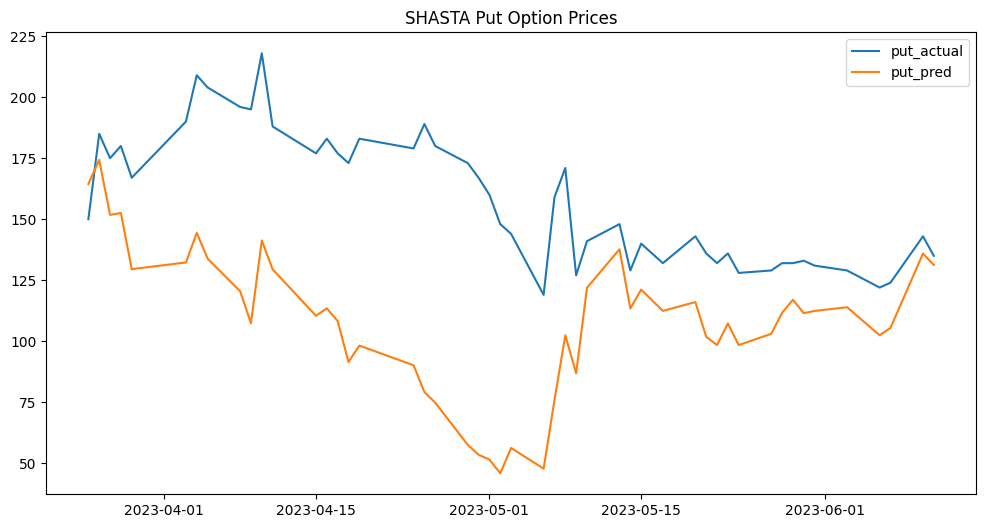

In [48]:
option_prices[['put_actual', 'put_pred']].plot(figsize=(12, 6), title='SHASTA Put Option Prices')

### Trade Strategy

This trading strategy is based on the assumption that the predicted prices for the next day (`call/put_pred`) provide an accurate forecast of what the actual prices (`call/put_actual`) will be.

The strategy is defined as follows:

1. **Buy signal**: If the predicted price for the next day is higher than the actual price for the current day, this is seen as a "Buy" signal. The logic here is that, if the price is expected to increase, buying now at the lower price would allow for a profit when selling at the higher price later.

The strategy iterates through the DataFrame, buying depending on whether the 'call/put_buy' signal is True. A counter of 'holdings' is kept to track the number of assets held, and 'cash' is updated each time a buy operation is made.

The cash remaining at the end of all the operations, including the value of any remaining holdings valued at the last known price, gives an estimate of the overall profit or loss made by this strategy.

It is important to note that this is a simplistic model and does not take into account various factors that could impact actual trading such as transaction costs, market impact, the inability to buy partial shares, and other complexities of real-world trading. It also assumes that the price predictions are perfectly accurate and that trades can be executed instantly at the predicted price, both of which are unlikely to be true in real-life scenarios. Therefore, while this strategy provides a useful starting point for backtesting trading strategies, it should not be used for actual trading without further refinement and testing.

#### Call Option

In [55]:
option_prices['call_buy'] = (option_prices['call_pred'].shift(-1) > option_prices['call_actual'])

# Initial holdings and cash
holdings = 0.0
cash = 10_000.0

for index, row in option_prices.iterrows():
    if row['call_buy'] and cash >= row['call_actual']:
        # can buy one unit
        holdings += 1
        cash -= row['call_actual']

# Add leftover holdings to cash at the last known price
cash += holdings * option_prices.iloc[-1]['call_actual']

print(f'Initial cash: 10,000')
print(f'Total cash after applying the strategy: {cash: .2f}')
print(f'Profit: {(cash - 10_000):.2f}')
print(f'Profit percentage: {((cash - 10_000) / 10_000 * 100):.2f}%')

Initial cash: 10,000
Total cash after applying the strategy:  10000.00
Profit: 0.00
Profit percentage: 0.00%


#### Put Option

In [54]:
option_prices['put_buy'] = (option_prices['put_pred'].shift(-1) > option_prices['put_actual'])

# Initial holdings and cash
holdings = 0.0
cash = 10_000.0

for index, row in option_prices.iterrows():
    if row['put_buy'] and cash >= row['put_actual']:
        # can buy one unit
        holdings += 1
        cash -= row['put_actual']

# Add leftover holdings to cash at the last known price
cash += holdings * option_prices.iloc[-1]['put_actual']

print(f'Initial cash: 10,000')
print(f'Total cash after applying the strategy: {cash: .2f}')
print(f'Profit: {(cash - 10_000):.2f}')
print(f'Profit percentage: {((cash - 10_000) / 10_000 * 100):.2f}%')

Initial cash: 10,000
Total cash after applying the strategy:  9996.00
Profit: -4.00
Profit percentage: -0.04%
